# Data Science Project Final Report
**By: Ricky Shi, Evan Chen, Mari **

---

## Data Description

This project uses two datasets, `players.csv` and `sessions.csv`, collected from a Minecraft research server operated by UBC’s Computer Science department. The data record player demographics and in-game activity. My analysis will primarily use `players.csv`, as it includes both predictors and the response variable.

| Dataset | Rows | Columns | Description |
|----------|------|----------|--------------|
| `players.csv` | 196 | 7 | Contains hashed emails (acts as player IDs) and variables such as age, gender, total playtime (hours), and newsletter subscription status |
| `sessions.csv` | 1535 | 5 | Contains session-level data, including hashed emails, start and end times, and timestamp equivalents |

**Potential Issues**
- Missing age for two players reduces usable data
- Extreme playtime values (e.g., idle sessions) may report inaccurate playtimes
- Subscription classes are imbalanced (many more “Yes” than “No”)
- Predictors use different scales and must be standardized

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Data Summary

In [7]:
players <- read_csv("https://github.com/FunkyMonkey245/dsci_project_planning_individual/raw/refs/heads/main/data/players.csv")

sessions <- read_csv("https://github.com/FunkyMonkey245/dsci_project_planning_individual/raw/refs/heads/main/data/sessions.csv")

players_summary <- players |>
    summarize(
        total_players = n(),
        subscribed_players = sum(subscribe == TRUE, na.rm = TRUE),
        unsubscribed_players = sum(subscribe == FALSE, na.rm = TRUE),
        subscribed_percent = round(100 * subscribed_players / total_players, 2),
        age_mean = round(mean(Age, na.rm = TRUE), 2),
        age_min  = min(Age, na.rm = TRUE),
        age_max  = max(Age, na.rm = TRUE),
        hours_mean = round(mean(played_hours, na.rm = TRUE), 2),
        hours_min  = min(played_hours, na.rm = TRUE),
        hours_max  = max(played_hours, na.rm = TRUE)
      )

sessions_summary <- sessions |>
    count(hashedEmail, name = "session_count") |>
    summarize(
        total_players = n(),
        total_sessions = sum(session_count),
        avg_sessions_per_player = mean(session_count),
        lowest_session_count = min(session_count),
        most_session_count = max(session_count)
      )
glimpse(players)
glimpse(sessions)
players_summary
sessions_summary

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+

total_players,subscribed_players,unsubscribed_players,subscribed_percent,age_mean,age_min,age_max,hours_mean,hours_min,hours_max
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,144,52,73.47,21.14,9,58,5.85,0,223.1


total_players,total_sessions,avg_sessions_per_player,lowest_session_count,most_session_count
<int>,<int>,<dbl>,<int>,<int>
125,1535,12.28,1,310


**Summary Report: `players.csv`**

- Total players: 196
- Subscribed players: 144
- Unsubscribed players: 52
- Percent Subscribed: 73.47%
- Average player age: 21.14 years
- Youngest player: 9 years
- Oldest player: 58 years
- Average total playtime: 5.85 hours
- Lowest playtime: 0 Hours
- Highest playtime: 223.10 Hours

## Establishing the Question

**Broad Question:**  
What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do they differ between various player types?

**Specific Question:**  
Can a player’s age and total playtime predict whether they subscribe to the game’s newsletter?

## Exploratory Data Analysis and Visualization

- For this section, I will use the `players.csv` dataset to summarize the mean of the predictor variables, and visualize their relationships with newsletter subscription in multiple plots.
- Not much wrangling is needed as the dataset is already tidy for my analysis

In [3]:
# Mean summary of predictor variables
mean_summary <- players |>
    summarize(
        mean_age = round(mean(Age, na.rm = TRUE), 2),
        mean_playtime = round(mean(played_hours, na.rm = TRUE), 2),
      )

mean_summary

mean_age,mean_playtime
<dbl>,<dbl>
21.14,5.85


**Plots Included**
- Scatterplot of age vs. playtime colored by subscription
- Bar plot comparing subscription counts across experience levels
- Histograms showing playtime distribution for subscribers vs non-subscribers
- Log10 scaling was applied to playtime variables to compress extreme values and clearly show clustered data

**Observations**
- Most players recorded under 10 hours of total playtime
- There is a weak negative relationship between age and playtime, where younger players tend to play more
- Subscribed players generally show more total playtime
- Amateurs and veterans have the most subscribers

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”


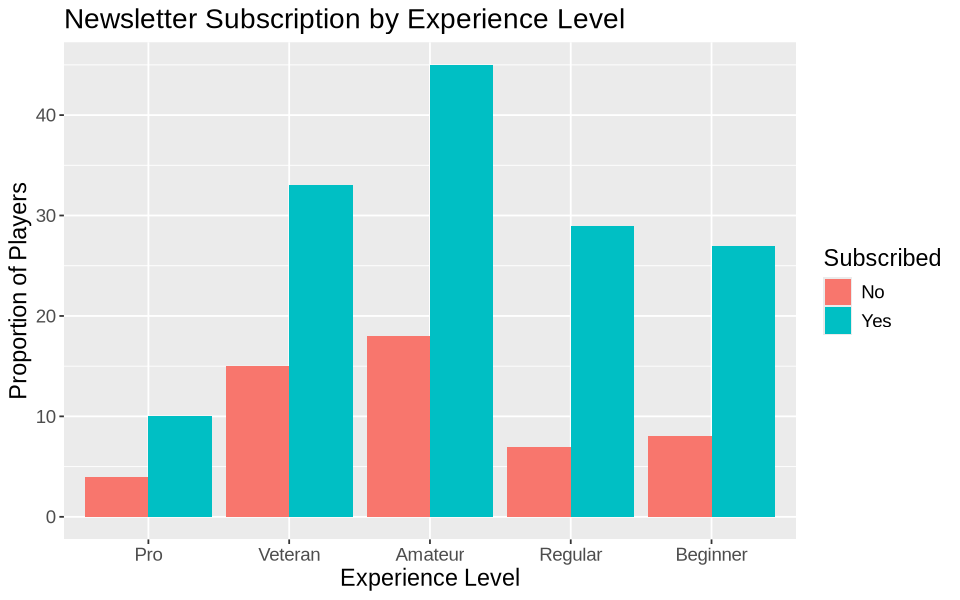

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


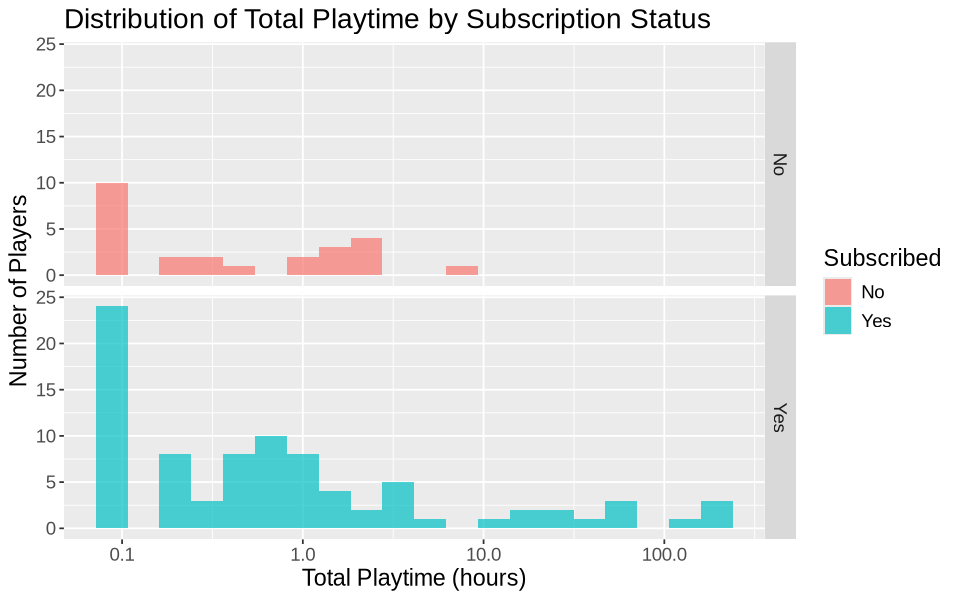

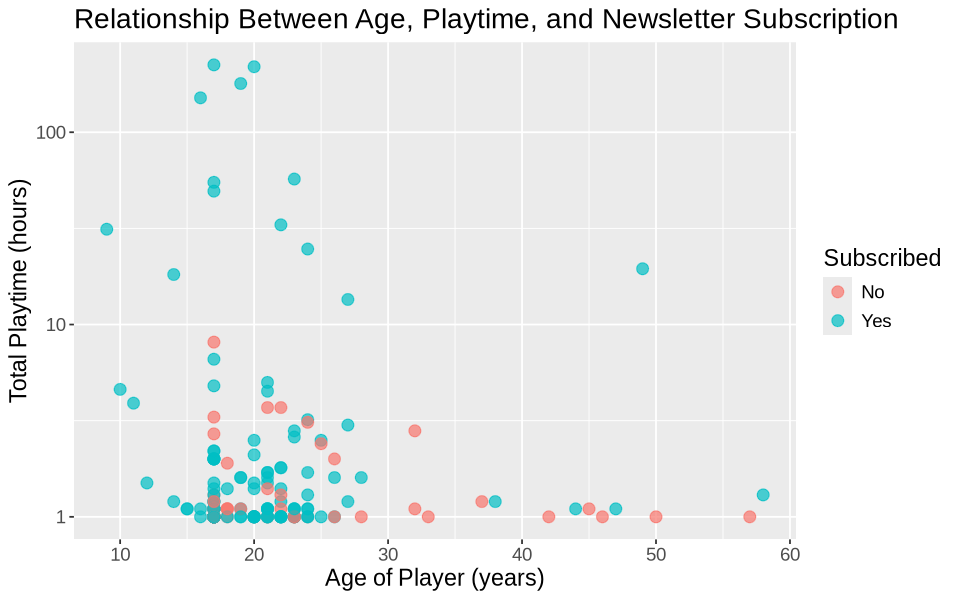

In [4]:
options(repr.plot.width = 8, repr.plot.height = 5)

#Data is already quite tidy, so changing the variable types is sufficient for my analysis

players <- players |>
    mutate(subscribe = as_factor(subscribe), subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"), experience = as_factor(experience))

# Plot visualizations showing the relationships between multiple variables in the players dataset

players_plot <- ggplot(players, aes(x = Age, y = played_hours + 1, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    scale_y_log10() +
    labs(x = "Age of Player (years)", y = "Total Playtime (hours)", color = "Subscribed") +
    ggtitle("Relationship Between Age, Playtime, and Newsletter Subscription") +
    theme(text = element_text(size = 14))

players_barplot <- ggplot(players, aes(x = experience, fill = subscribe)) +
    geom_bar(position = "dodge") +
    labs(title = "Newsletter Subscription by Experience Level", x = "Experience Level", y = "Proportion of Players", fill = "Subscribed") +
    theme(text = element_text(size = 14))

players_histogram <- ggplot(players, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 20, alpha = 0.7, position = "identity") +
    facet_grid(rows = vars(subscribe)) +
    scale_x_log10() +
    labs(title = "Distribution of Total Playtime by Subscription Status", x = "Total Playtime (hours)", y = "Number of Players", fill = "Subscribed") +
    theme(text = element_text(size = 14))

players_barplot
players_histogram
players_plot 

## Methods and Plan

I will use a K-NN classification model to predict subscription status using age and playtime.

**Why this model?**
- It is suitable for categorical prediction using numerical predictors
- It does not require any particular relationship between the predictors and the outcome variables, but only uses nearby datapoints

**Assumptions & Preparation**
- Predictors will be standardized in a recipe using scaling and centering
- Missing ages will be filled using the mean age

**Limitations**
- Class imbalance (more subscribers) can bias results  
- Extreme points could overly influence distance-based calculations

**Model Selection & Evaluation**
- I will tune K (1–10) via 5-fold cross-validation using accuracy as the main metric
- Data is split into 70% training, 30% testing 
- The K with highest validation accuracy will be used to fit the final model and the accuracy on the test data will be used to answer the question